In [25]:
import os
import sys
import skimage.io as io
import random
import json
import pickle

import math
import numpy as np
from collections import Counter
import nltk
nltk.download('punkt')
import torch
import torch.utils.data as DataSet
from pycocotools.coco import COCO

from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

[nltk_data] Downloading package punkt to /home/nboren/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
validationName = 'val2017'
DATA_PATH = '../data/'

# Data Visulization

In [3]:
instance_annotations = os.path.join(DATA_PATH, 'annotations/sama_coco_coco_format_{}.json'.format('val_1'))
coco = COCO(instance_annotations)

captions_annotations = os.path.join(DATA_PATH, 'annotations/captions_{}.json'.format(validationName))
coco_captions = COCO(captions_annotations)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [4]:
instance_annotations_train = os.path.join(DATA_PATH, 'annotations/sama_coco_coco_format_{}.json'.format('train_1'))
coco_train = COCO(instance_annotations_train)

captions_annotations_train = os.path.join(DATA_PATH, 'annotations/captions_{}.json'.format('train2017'))
coco_captions_train = COCO(captions_annotations_train)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.72s)
creating index...
index created!


In [5]:
cats = coco.loadCats(coco.getCatIds())
nms = [cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
food sports kitchen furniture appliance vehicle animal electronic accessory indoor person outdoor


In [6]:
ids = list(coco.anns.keys())
ann_id = np.random.choice(ids)
#rint(coco.anns[ann_id])
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']
print(img)

# print URL and visualize corresponding image
print(url)
# = io.imread(url)
#lt.axis('off')
#lt.imshow(I)
#lt.show()

# load and display captions
annIds = coco_captions.getAnnIds(imgIds=img['id']);
anns = coco_captions.loadAnns(annIds)
coco_captions.showAnns(anns)

{'license': 3, 'file_name': '000000437239.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000437239.jpg', 'height': 425, 'width': 640, 'date_captured': '2013-11-18 18:34:04', 'flickr_url': 'http://farm4.staticflickr.com/3508/3737478305_e4b7a1a981_z.jpg', 'id': 437239}
http://images.cocodataset.org/val2017/000000437239.jpg
A group of people standing on a field playing disc golf.
A group of people stand next to a bench outside.
A group of people standing beside a bench with frisbees.
Three men and a woman in the park with frisbees. 
A group of people who are outside holding a Frisbee.


{'license': 1, 'file_name': '000000388761.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000388761.jpg', 'height': 470, 'width': 640, 'date_captured': '2013-11-16 22:22:41', 'flickr_url': 'http://farm4.staticflickr.com/3401/3497168730_daf8b0b429_z.jpg', 'id': 388761}
http://images.cocodataset.org/train2017/000000388761.jpg


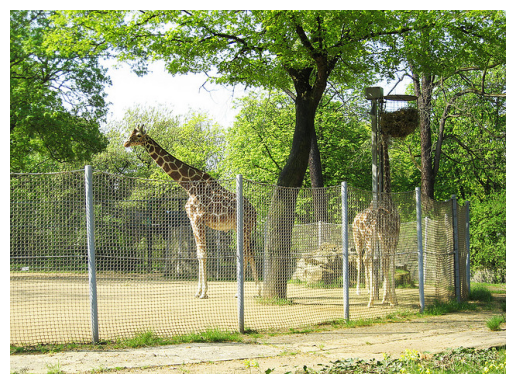

A couple of giraffe standing next to each other.
An outdoor area that has high fences, with two giraffe inside the fence area near trees and a feeding basket hanging up high.
Two giraffes inside a pen probably at a zoo 
The giraffes are standing among the trees inside the fence.
Two giraffes locked in an enclosure behind a fence


In [7]:
ids = list(coco_train.anns.keys())
ann_id = np.random.choice(ids)
#print(coco.anns[ann_id])
img_id = coco_train.anns[ann_id]['image_id']
img = coco_train.loadImgs(img_id)[0]
url = img['coco_url']
print(img)

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_captions_train.getAnnIds(imgIds=img['id']);
anns = coco_captions_train.loadAnns(annIds)
coco_captions_train.showAnns(anns)

# Data Preperation

In [8]:
class WordVocabulary:
    def __init__(self,
        vocab_threshold,
        vocab_file='./word_vocab.pkl',
        start_word='<start>',
        end_word='<end>',
        unk_word="<unk>",
        annotations_file='../data/annotations/captions_train2017.json',
        vocab_from_file=False,
        verbose=False):
        """Initialize the word vocabulary.
        Args:
          vocab_threshold: Minimum word count threshold.
          vocab_file: File containing the vocabulary.
          start_word: Special word denoting sentence start.
          end_word: Special word denoting sentence end.
          unk_word: Special word denoting unknown words.
          annotations_file: Path for train annotation file.
          vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           If True, load vocab from from existing vocab_file, if it exists
          verbose: If true, print out iterations. 
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.word2idx = dict()
        self.idx2word = dict()
        self.verbose = verbose
        self.get_vocab()
    
    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) and self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
                
            print('Word Vocabulary successfully loaded from {} file'.format(self.vocab_file))
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
            
            print('Word Vocabulary succesfully created at {}'.format(self.vocab_file))
            
    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        idx = 0
        coco_captions = COCO(self.annotations_file)
        counter = Counter()
        ids = coco_captions.anns.keys()
        
        def add_word(word, idx):
            """Add the given word token to vocab"""
            if not word in self.word2idx:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx = idx + 1
                
            return idx
                
        idx = add_word(self.start_word, idx)
        idx = add_word(self.end_word, idx)
        idx = add_word(self.unk_word, idx)
        
        if self.verbose:
            print(f'Current idx: {idx}')
            print('Current word2idx:', self.word2idx)
            
        for i, caption_id in enumerate(ids):
            caption = str(coco_captions.anns[caption_id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)
            
            if self.verbose and i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))
            
        words = []
        for word, count in counter.items():
            if count >= self.vocab_threshold:
                words.append(word)
                
        for word in words:
            idx = add_word(word, idx)

    def __getitem__(self, word):
        if not word in self.word2idx:  
            return self.word2idx[self.unk_word]
        
        return self.word2idx[word]
    
    def __len__(self):
        return len(self.word2idx)
        

In [9]:
vocab = WordVocabulary(10, verbose=True, vocab_from_file=True)

Word Vocabulary successfully loaded from ./word_vocab.pkl file


In [10]:
class CharVocabulary:
    def __init__(self,
        vocab_threshold,
        vocab_file='./char_vocab.pkl',
        unk_char='<unk>',
        annotations_file='../data/annotations/captions_train2017.json',
        vocab_from_file=False,
        verbose=False):
        """Initialize the char vocabulary.
        Args:
          vocab_threshold: Minimum word count threshold.
          vocab_file: File containing the vocabulary.
          unk_char: Special word denoting unknown chars.
          annotations_file: Path for train annotation file.
          vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           If True, load vocab from from existing vocab_file, if it exists
          verbose: If true, print out iterations. 
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.unk_char = unk_char
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.char2idx = dict()
        self.idx2char = dict()
        self.verbose = verbose
        self.get_vocab()
    
    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) and self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.char2idx = vocab.char2idx
                self.idx2char = vocab.idx2char
                
            print('Char Vocabulary successfully loaded from {} file'.format(self.vocab_file))
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
            
            print('Char Vocabulary succesfully created at {}'.format(self.vocab_file))
            
    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        idx = 0
        coco_captions = COCO(self.annotations_file)
        counter = Counter()
        ids = coco_captions.anns.keys()
        
        def add_char(word, idx):
            """Add the given char  token to vocab"""
            for char in word:
                if not char in self.char2idx:
                    self.char2idx[char] = idx
                    self.idx2char[idx] = char
                    idx = idx + 1

                return idx
                
        self.char2idx[self.unk_char] = idx
        self.idx2char[idx] = self.unk_char
        idx = idx + 1
        
        if self.verbose:
            print(f'Current idx: {idx}')
            print('Current char2idx:', self.char2idx)
            
        for i, caption_id in enumerate(ids):
            caption = str(coco_captions.anns[caption_id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)
            
            if self.verbose and i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))
            
        words = []
        for word, count in counter.items():
            if count >= self.vocab_threshold:
                words.append(word)
                
        for word in words:
            idx = add_char(word, idx)

    def __getitem__(self, char):
        if not char in self.char2idx:  
            return self.char2idx[self.unk_char]
        
        return self.char2idx[char]
    
    def __len__(self):
        return len(self.char2idx)

In [12]:
char_vocab = CharVocabulary(10, verbose=True, vocab_from_file=True)

Char Vocabulary successfully loaded from ./char_vocab.pkl file


In [13]:
char_vocab['e']

17

# Data Loader

In [18]:
class CoCoDataset:
    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, 
    end_word, unk_word, annotations_file, vocab_from_file, img_folder, use_word_vocab=True,):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        # if statement for word or char vocab
        self.use_word_vocab = use_word_vocab
        if use_word_vocab:
          self.vocab = WordVocabulary(vocab_threshold, vocab_file, start_word,
              end_word, unk_word, annotations_file, vocab_from_file, verbose=False)
        else:
          self.vocab = CharVocabulary(vocab_threshold, vocab_file, unk_word, annotations_file,
                                      vocab_from_file, verbose=False)     
        self.img_folder = img_folder
        if self.mode == 'train':
            self.coco = COCO(annotations_file)
            self.ids = list(self.coco.anns.keys())
            print('Obtaining caption lengths...')
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]

    def __getitem__(self, index):
      # obtain image and caption if in training mode
      if self.mode == 'train':
          ann_id = self.ids[index]
          caption = self.coco.anns[ann_id]['caption']
          img_id = self.coco.anns[ann_id]['image_id']
          path = self.coco.loadImgs(img_id)[0]['file_name']

          # Convert image to tensor and pre-process using transform
          image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
          image = self.transform(image)

          # Convert caption to tensor of word ids.
          tokens = nltk.tokenize.word_tokenize(str(caption).lower())
          caption = []
          if self.use_word_vocab:
            caption.append(self.vocab[self.vocab.start_word])
          caption.extend([self.vocab[token] for token in tokens])
          if self.use_word_vocab:
            caption.append(self.vocab[self.vocab.end_word])
          caption = torch.Tensor(caption).long()

          # return pre-processed image and caption tensors
          return image, caption

      # obtain image if in test mode
      else:
          path = self.paths[index]

          # Convert image to tensor and pre-process using transform
          PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
          orig_image = np.array(PIL_image)
          image = self.transform(PIL_image)

          # return original image and pre-processed image tensor
          return orig_image, image

    def get_train_indices(self):
      sel_length = np.random.choice(self.caption_lengths)
      all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
      indices = list(np.random.choice(all_indices, size=self.batch_size))
      return indices

    def __len__(self):
      if self.mode == 'train':
          return len(self.ids)
      else:
          return len(self.paths)

In [19]:
def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./word_vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0,
               #cocoapi_loc='/content/drive/MyDrive/CSE_DL_Final_Project/cocoapi-master/'
               use_word_vocab=True
               ):
    """Returns the data loader.
    Args:
      transform: Image transform.
      mode: One of 'train' or 'test'.
      batch_size: Batch size (if in testing mode, must have batch_size=1).
      vocab_threshold: Minimum word count threshold.
      vocab_file: File containing the vocabulary. 
      start_word: Special word denoting sentence start.
      end_word: Special word denoting sentence end.
      unk_word: Special word denoting unknown words.
      vocab_from_file: If False, create vocab from scratch & override any existing vocab_file.
                       If True, load vocab from from existing vocab_file, if it exists.
      num_workers: Number of subprocesses to use for data loading 
      cocoapi_loc: The location of the folder containing the COCO API: https://github.com/cocodataset/cocoapi
      use_word_vocab: If True we use WordVocabulary, if False, we use CharVocabulary
    """
    assert mode in ['train', 'test'], "mode must be one of 'train' or 'test'."
    if vocab_from_file==False: assert mode=='train', "To generate vocab from captions file, must be in training mode (mode='train')."
          # Based on mode (train, val, test), obtain img_folder and annotations_file.

    # have not looked at this code yet...
    if mode == 'train':
      if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        #img_folder = os.path.join(cocoapi_loc, 'data/MyDrive/CSE_DL_Final_Project/data/images/val2014/')
        #annotations_file = os.path.join(cocoapi_loc, 'data/MyDrive/CSE_DL_Final_Project/data/annotations/captions_val2014.json')
      img_folder = '../data/images/val2017/'
      annotations_file = '../data/annotations/captions_val2017.json'
    if mode == 'test':
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = '../data/images/test2017/'
        annotations_file = '../data/annotations/image_info_test2017.json'

    # COCO caption dataset.
    dataset = CoCoDataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder,
                          use_word_vocab=use_word_vocab)

    
    if mode == 'train':
      # Randomly sample a caption length, and sample indices with that length.
      indices = dataset.get_train_indices()
      # Create and assign a batch sampler to retrieve a batch with the sampled indices.
      initial_sampler = DataSet.sampler.SubsetRandomSampler(indices=indices)
      # data loader for COCO dataset.
      data_loader = DataSet.DataLoader(dataset=dataset, 
                                    num_workers=num_workers,
                                    batch_sampler=DataSet.sampler.BatchSampler(sampler=initial_sampler,
                                                                            batch_size=dataset.batch_size,
                                                                            drop_last=False))
    else:
        data_loader = DataSet.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader

In [20]:
from torchvision import transforms
# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 6

# Specify the batch size.
batch_size = 10

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         vocab_file='./char_vocab.pkl',
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False,
                         use_word_vocab=False)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Char Vocabulary succesfully created at ./char_vocab.pkl
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 25014/25014 [00:02<00:00, 12137.16it/s]


# Model

In [21]:
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        ''' Initialize the layers of this model.'''
        super().__init__()
    
        # Keep track of hidden_size for initialization of hidden state
        self.hidden_size = hidden_size
        
        # Embedding layer that turns words into a vector of a specified size
        self.word_embeddings = nn.Embedding(vocab_size, embed_size)
        
        # The LSTM takes embedded word vectors (of a specified size) as input
        # and outputs hidden states of size hidden_dim
        self.lstm = nn.LSTM(input_size=embed_size, \
                            hidden_size=hidden_size, # LSTM hidden units 
                            num_layers=1, # number of LSTM layer
                            bias=True, # use bias weights b_ih and b_hh
                            batch_first=True,  # input & output will have batch size as 1st dimension
                            dropout=0, # Not applying dropout 
                            bidirectional=False, # unidirectional LSTM
                           )
        
        # The linear layer that maps the hidden state output dimension
        # to the number of words we want as output, vocab_size
        self.linear = nn.Linear(hidden_size, vocab_size)                     

        # initialize the hidden state
        # self.hidden = self.init_hidden()


    def init_hidden(self, batch_size):
      """ At the start of training, we need to initialize a hidden state;
      there will be none because the hidden state is formed based on previously seen data.
      So, this function defines a hidden state with all zeroes
      The axes semantics are (num_layers, batch_size, hidden_dim)
      """
      return (torch.zeros((1, batch_size, self.hidden_size), device=device), \
              torch.zeros((1, batch_size, self.hidden_size), device=device))
    

    def forward(self, features, captions):
      """ Define the feedforward behavior of the model """
      
      # Discard the <end> word to avoid predicting when <end> is the input of the RNN
      captions = captions[:, :-1]     
      
      # Initialize the hidden state
      batch_size = features.shape[0] # features is of shape (batch_size, embed_size)
      self.hidden = self.init_hidden(batch_size) 
              
      # Create embedded word vectors for each word in the captions
      embeddings = self.word_embeddings(captions) # embeddings new shape : (batch_size, captions length - 1, embed_size)
      
      # Stack the features and captions
      embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1) # embeddings new shape : (batch_size, caption length, embed_size)
      
      # Get the output and hidden state by passing the lstm over our word embeddings
      # the lstm takes in our embeddings and hidden state
      lstm_out, self.hidden = self.lstm(embeddings, self.hidden) # lstm_out shape : (batch_size, caption length, hidden_size)

      # Fully connected layer
      outputs = self.linear(lstm_out) # outputs shape : (batch_size, caption length, vocab_size)

      return outputs


    ## Greedy search 
    def sample(self, inputs):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "
        
        
        output = []
        batch_size = inputs.shape[0] # batch_size is 1 at inference, inputs shape : (1, 1, embed_size)
        hidden = self.init_hidden(batch_size) # Get initial hidden state of the LSTM
    
        while True:
            lstm_out, hidden = self.lstm(inputs, hidden) # lstm_out shape : (1, 1, hidden_size)
            outputs = self.linear(lstm_out)  # outputs shape : (1, 1, vocab_size)
            outputs = outputs.squeeze(1) # outputs shape : (1, vocab_size)
            _, max_indice = torch.max(outputs, dim=1) # predict the most likely next word, max_indice shape : (1)
            
            output.append(max_indice.cpu().numpy()[0].item()) # storing the word predicted
            
            if (max_indice == 1):
                # We predicted the <end> word, so there is no further prediction to do
                break
            
            ## Prepare to embed the last predicted word to be the new input of the lstm
            inputs = self.word_embeddings(max_indice) # inputs shape : (1, embed_size)
            inputs = inputs.unsqueeze(1) # inputs shape : (1, 1, embed_size)
            
        return output


    ## Beam search implementation (Attempt)
    def beam_search_sample(self, inputs, beam=3):
        output = []
        batch_size = inputs.shape[0] # batch_size is 1 at inference, inputs shape : (1, 1, embed_size)
        hidden = self.init_hidden(batch_size) # Get initial hidden state of the LSTM
        
        # sequences[0][0] : index of start word
        # sequences[0][1] : probability of the word predicted
        # sequences[0][2] : hidden state related of the last word
        sequences = [[[torch.Tensor([0])], 1.0, hidden]]
        max_len = 20

        ## Step 1
        # Predict the first word <start>
        outputs, hidden = DecoderRNN.get_outputs(self, inputs, hidden)
        _, max_indice = torch.max(outputs, dim=1) # predict the most likely next word, max_indice shape : (1)
        output.append(max_indice.cpu().numpy()[0].item()) # storing the word predicted 
        # inputs = DecoderRNN.get_next_word_input(self, max_indice)
        
        
        l = 0
        while len(sequences[0][0]) < max_len: 
            print("l:", l)
            l+= 1
            temp = []
            for seq in sequences:
#                 print("seq[0]: ", seq[0])
                inputs = seq[0][-1] # last word index in seq
                inputs = inputs.type(torch.cuda.LongTensor)
                print("inputs : ", inputs)
                # Embed the input word
                inputs = self.word_embeddings(inputs) # inputs shape : (1, embed_size)
                inputs = inputs.unsqueeze(1) # inputs shape : (1, 1, embed_size) 
                
                # retrieve the hidden state
                hidden = seq[2]
                
                preds, hidden = DecoderRNN.get_outputs(self, inputs, hidden)

                # Getting the top <beam_index>(n) predictions
                softmax_score = F.log_softmax(outputs, dim=1) # Define a function to sort the cumulative score
                sorted_score, indices = torch.sort(-softmax_score, dim=1)
                word_preds = indices[0][:beam]
                best_scores = sorted_score[0][:beam]

                # Creating a new list so as to put them via the model again
                for i, w in enumerate(word_preds):
#                     print("seq[0]: ", seq[0][0][:].cpu().numpy().item())
                    next_cap, prob = seq[0][0].cpu().numpy().tolist(), seq[1]
                    
                    next_cap.append(w)
                    print("next_cap : ", next_cap)
                    prob *best_scores[i].cpu().item()
                    temp.append([next_cap, prob])

            sequences = temp
            # Order according to proba
            ordered = sorted(sequences, key=lambda tup: tup[1])

            # Getting the top words
            sequences = ordered[:beam]
            print("sequences: ", sequences)


    def get_outputs(self, inputs, hidden):
        lstm_out, hidden = self.lstm(inputs, hidden) # lstm_out shape : (1, 1, hidden_size)
        outputs = self.linear(lstm_out)  # outputs shape : (1, 1, vocab_size)
        outputs = outputs.squeeze(1) # outputs shape : (1, vocab_size)

        return outputs, hidden


    def get_next_word_input(self, max_indice):
        ## Prepare to embed the last predicted word to be the new input of the lstm
        inputs = self.word_embeddings(max_indice) # inputs shape : (1, embed_size)
        inputs = inputs.unsqueeze(1) # inputs shape : (1, 1, embed_size)

        return inputs

In [23]:
# Randomly sample a caption length, and sample indices with that length.
indices = data_loader.dataset.get_train_indices()
print('sampled indices:', indices)

# Create and assign a batch sampler to retrieve a batch with the sampled indices.
new_sampler = DataSet.sampler.SubsetRandomSampler(indices=indices)
data_loader.batch_sampler.sampler = new_sampler
    
# Obtain the batch.
images, captions = next(iter(data_loader))






# Specify the dimensionality of the image embedding.
embed_size = 512

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Initialize the encoder. (Optional: Add additional arguments if necessary.)
encoder = EncoderCNN(embed_size)

# Move the encoder to GPU if CUDA is available.
encoder.to(device)
    
# Move last batch of images (from Step 2) to GPU if CUDA is available.   
images = images.to(device)

# Pass the images through the encoder.
features = encoder(images)

print('type(features):', type(features))
print('features.shape:', features.shape)

# Check that your encoder satisfies some requirements of the project! :D
assert type(features)==torch.Tensor, "Encoder output needs to be a PyTorch Tensor." 
assert (features.shape[0]==batch_size) & (features.shape[1]==embed_size), "The shape of the encoder output is incorrect."



# Specify the number of features in the hidden state of the RNN decoder.
hidden_size = 512

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Store the size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the decoder.
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move the decoder to GPU if CUDA is available.
decoder.to(device)
    
# Move last batch of captions (from Step 1) to GPU if CUDA is available 
captions = captions.to(device)

# Pass the encoder output and captions through the decoder.
outputs = decoder(features, captions)

print('type(outputs):', type(outputs))
print('outputs.shape:', outputs.shape)

# Check that your decoder satisfies some requirements of the project! :D
assert type(outputs)==torch.Tensor, "Decoder output needs to be a PyTorch Tensor."
assert (outputs.shape[0]==batch_size) & (outputs.shape[1]==captions.shape[1]) & (outputs.shape[2]==vocab_size), "The shape of the decoder is incorrect."

sampled indices: [4487, 14156, 8544, 16966, 3228, 15575, 6269, 17273, 12814, 11567]
type(features): <class 'torch.Tensor'>
features.shape: torch.Size([10, 512])
type(outputs): <class 'torch.Tensor'>
outputs.shape: torch.Size([10, 9, 36])


# Hyper-params

In [28]:
## TODO #1: Select appropriate values for the Python variables below.
batch_size = 32          # batch size
vocab_threshold = 6        # minimum word count threshold
vocab_from_file = True    # if True, load existing vocab file
embed_size = 512           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 1             # number of training epochs (1 for testing)
save_every = 1             # determines frequency of saving model weights
print_every = 200          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

# (Optional) TODO #2: Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file,
                         use_word_vocab=True)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# TODO #3: Specify the learnable parameters of the model.
params = list(decoder.parameters()) + list(encoder.embed.parameters()) + list(encoder.resnet.parameters())

# TODO #4: Define the optimizer.
optimizer = torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.Adam(params, lr=0.01, betas=(0.9, 0.999), eps=1e-08)
# optimizer = torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

Word Vocabulary successfully loaded from ./word_vocab.pkl file
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 25014/25014 [00:02<00:00, 10682.95it/s]


# Train

In [29]:
import requests
import time

# Open the training log file.
f = open(log_file, 'w')

old_time = time.time()
#response = requests.request("GET", 
                            #"http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", 
                            #headers={"Metadata-Flavor":"Google"})

for epoch in range(1, num_epochs+1):
    
    for i_step in range(1, total_step+1):
        
        if time.time() - old_time > 60:
            old_time = time.time()
            #requests.request("POST", 
                             #"https://nebula.udacity.com/api/v1/remote/keep-alive", 
                             #headers={'Authorization': "STAR " + response.text})
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = DataSet.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler

        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
#         print("outputs.shape: ", outputs.shape)
        loss = criterion(outputs.contiguous().view(-1, vocab_size), captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()

          # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        # Print training statistics to file.
        f.write(stats + '\n')
        f.flush()
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), os.path.join('./models', 'decoder-%d.pkl' % epoch))
        torch.save(encoder.state_dict(), os.path.join('./models', 'encoder-%d.pkl' % epoch))

# Close the training log file.
f.close()

Epoch [1/1], Step [200/782], Loss: 3.3270, Perplexity: 27.85599
Epoch [1/1], Step [400/782], Loss: 3.1667, Perplexity: 23.7296
Epoch [1/1], Step [600/782], Loss: 3.0389, Perplexity: 20.8819
Epoch [1/1], Step [782/782], Loss: 2.6779, Perplexity: 14.5547

FileNotFoundError: [Errno 2] No such file or directory: './models/decoder-1.pkl'